In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from smyleutils import averaging_utils as avg
from smyleutils import qboplot_utils as qbo
from smyleutils import colorbar_utils as cbars
from smyleutils import bootstrap_utils as boot
from smyleutils import zmplot_utils as zmplot
from smyleutils import plothisto_utils as histo

import dask

In [2]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

In [6]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '30GB',
    processes = 1,
    queue = 'casper',
    local_directory = '$TMPDIR',
    resource_spec = 'select=1:ncpus=1:mem=30GB',
    project='P04010022',
    walltime='04:00:00',
    interface='mgt')

# scale up
cluster.scale(12)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/islas/miniconda3/envs/islaenv24/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45333 instead
  f"Port {expected} is already in use.\n"


In [10]:
cluster

PBSCluster(02555b77, 'tcp://10.18.206.66:45119', workers=12, threads=12, memory=335.28 GiB)

### Read in the zonal wind data for the QBO

In [11]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"

high_nov=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E-L83_day_init11.nc')
low_nov=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E_day_init11.nc') ; low_nov['lat'] = high_nov.lat
era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc') ; era5_nov['lat'] = high_nov.lat
jra3q_nov = xr.open_dataset(basepath+'Uzm_JRA3Q_day_init11.nc') ; jra3q_nov['lat'] = high_nov.lat

high_nov = high_nov.Uzm
low_nov = low_nov.Uzm
era5_nov = era5_nov.Uzm
jra3q_nov = jra3q_nov.Uzm

### Compute the monthly average anomaly from the lead dependent climatology and grab out January

In [12]:
high_nov_mon = high_nov.groupby('time.month').mean('time')
low_nov_mon = low_nov.groupby('time.month').mean('time')
era5_nov_mon = era5_nov.groupby('time.month').mean('time')
jra3q_nov_mon = jra3q_nov.groupby('time.month').mean('time')

In [13]:
high_nov_mon = high_nov_mon - high_nov_mon.mean('init_year')
low_nov_mon = low_nov_mon - low_nov_mon.mean('init_year')
era5_nov_mon = era5_nov_mon - era5_nov_mon.mean('init_year')
jra3q_nov_mon = jra3q_nov_mon - jra3q_nov_mon.mean('init_year')

In [14]:
high_nov_mon = high_nov_mon.sel(month=1)
low_nov_mon = low_nov_mon.sel(month=1)
era5_nov_mon = era5_nov_mon.sel(month=1)
jra3q_nov_mon = jra3q_nov_mon.sel(month=1)

### Grab out 50 hPa, 5S-5N for the QBO

In [15]:
high_nov_50 = high_nov_mon.interp(ilev=50)
low_nov_50 = low_nov_mon.interp(ilev=50)
era5_nov_50 = era5_nov_mon.sel(level=50)
jra3q_nov_50 = jra3q_nov_mon.sel(pre=50)

era5_nov_tr = avg.cosweightlat(era5_nov_50,-5,5)
jra3q_nov_tr = avg.cosweightlat(jra3q_nov_50,-5,5)
high_nov_tr = avg.cosweightlat(high_nov_50,-5,5)
low_nov_tr = avg.cosweightlat(low_nov_50,-5,5)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


### Read in the NAO data and grab out January

In [16]:
nao = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/NAO/NAO_eof_and_station_init11.nc")

nao_jan = nao.where( nao.time.dt.month == 1, drop=True).isel(time=0)

era5_nao_eof = nao_jan.ERA5_NAO_EOFbased
jra3q_nao_eof = nao_jan.JRA3Q_NAO_EOFbased
high_nao_eof = nao_jan.L83_NAO_EOFbased
low_nao_eof = nao_jan.L32_NAO_EOFbased
era5_nao_station = nao_jan.ERA5_NAO_stationbased
jra3q_nao_station = nao_jan.JRA3Q_NAO_stationbased
high_nao_station = nao_jan.L83_NAO_stationbased
low_nao_station = nao_jan.L32_NAO_stationbased

### Correlate the QBO and the NAO

In [21]:
era5_cor_eof = xr.corr(era5_nov_tr, era5_nao_eof, dim='init_year')
era5_cor_station = xr.corr(era5_nov_tr, era5_nao_station, dim='init_year')
jra3q_cor_eof = xr.corr(jra3q_nov_tr, jra3q_nao_eof, dim='init_year')
jra3q_cor_station = xr.corr(jra3q_nov_tr, jra3q_nao_station, dim='init_year')
high_cor_eof = xr.corr(high_nov_tr.mean('M'), high_nao_eof.mean('M'), dim='init_year')
high_cor_station = xr.corr(high_nov_tr.mean('M'), high_nao_station.mean('M'), dim='init_year')
low_cor_eof = xr.corr(low_nov_tr.mean('M'), low_nao_eof.mean('M'), dim='init_year')
low_cor_station = xr.corr(low_nov_tr.mean('M'), low_nao_station.mean('M'), dim='init_year')

### Generate single member bootstrapped samples from L83

In [18]:
boot_nao_eof = [] ; boot_nao_station = [] ; boot_qbo = []
for iyear in np.arange(0,high_nov_tr.init_year.size,1):
    boot_nao_eof_temp = boot.bootgen(high_nao_eof.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_nao_station_temp = boot.bootgen(high_nao_station.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_qbo_temp = boot.bootgen(high_nov_tr.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_nao_eof.append(boot_nao_eof_temp)
    boot_nao_station.append(boot_nao_station_temp)
    boot_qbo.append(boot_qbo_temp)
boot_nao_eof = xr.concat(boot_nao_eof, dim=high_nov_tr.init_year)
boot_nao_station = xr.concat(boot_nao_station, dim=high_nov_tr.init_year)
boot_qbo = xr.concat(boot_qbo, dim=high_nov_tr.init_year)

In [27]:
boot_cor_eof = xr.corr(boot_qbo, boot_nao_eof, dim='init_year')
boot_cor_station = xr.corr(boot_qbo, boot_nao_station, dim='init_year')

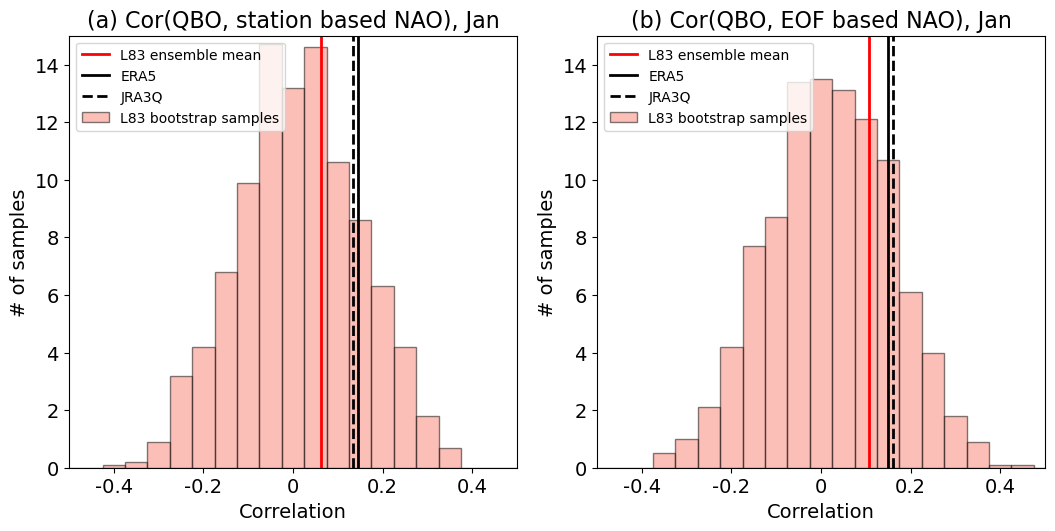

In [32]:
fig = plt.figure(figsize=(16,16))

ax = histo.plothisto(fig, boot_cor_station, np.arange(-1,1,0.05), 0.02, 0.3, 0.73, 1, percent=True, color='salmon', alpha=0.5,label='L83 bootstrap samples')
ax.set_title('(a) Cor(QBO, station based NAO), Jan', fontsize=16)
ax.set_xlim(-0.5,0.5)
ax.set_xticks([-0.4,-0.2,0,0.2,0.4])
ax.set_xticklabels(['-0.4','-0.2','0','0.2','0.4'], fontsize=14)
ax.set_xlabel('Correlation', fontsize=14)
ax.set_ylabel('# of samples', fontsize=14)
ax.set_ylim(0,15)
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_yticklabels(['0','2','4','6','8','10','12','14'], fontsize=14)
ax.plot([high_cor_station, high_cor_station],[0,15], color='red', linewidth=2, label='L83 ensemble mean')
ax.plot([era5_cor_station,era5_cor_station],[0,15], color='black', linewidth=2, label='ERA5')
ax.plot([jra3q_cor_station,jra3q_cor_station],[0,15], color='black', linestyle='dashed', linewidth=2, label='JRA3Q')
ax.legend(fontsize=10)


ax = histo.plothisto(fig, boot_cor_eof, np.arange(-1,1,0.05), 0.35, 0.63, 0.73, 1, percent=True, color='salmon', alpha=0.5,label='L83 bootstrap samples')
ax.set_title('(b) Cor(QBO, EOF based NAO), Jan', fontsize=16)
ax.set_xlim(-0.5,0.5)
ax.set_xticks([-0.4,-0.2,0,0.2,0.4])
ax.set_xticklabels(['-0.4','-0.2','0','0.2','0.4'], fontsize=14)
ax.set_xlabel('Correlation', fontsize=14)
ax.set_ylabel('# of samples', fontsize=14)
ax.set_ylim(0,15)
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_yticklabels(['0','2','4','6','8','10','12','14'], fontsize=14)
ax.plot([high_cor_eof, high_cor_eof],[0,15], color='red', linewidth=2, label='L83 ensemble mean')
ax.plot([era5_cor_eof,era5_cor_eof],[0,15], color='black', linewidth=2, label='ERA5')
ax.plot([jra3q_cor_eof,jra3q_cor_eof],[0,15], color='black', linestyle='dashed', linewidth=2, label='JRA3Q')
ax.legend(fontsize=10)

fig.savefig(plotpath+'fig9.png', bbox_inches='tight', facecolor='white')